In [137]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json
# import cabinetry

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax

import pyhf
from pyhf.contrib.viz import brazil
# pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from Bayesian_pyhf import infer
from Bayesian_pyhf import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
blue = '#7CA1CC' # '#A8B6CC'
rosa =  '#E57A77'

### Build workspace

In [104]:
nBins = 20

mgg_bins = np.linspace(100, 160, nBins)


gamma_noise =  np.random.gamma(3, 5, size=nBins)

background = list(reversed(100*np.exp(np.linspace(0, 2, nBins))))
background[nBins-1] = 100
signal = 900*sps.norm.pdf(mgg_bins, 125, 3) + np.random.normal(0, 15, size=nBins)
data = signal+background+np.random.gamma(3, 5, size=nBins)


/tmp/ipykernel_179733/918841728.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(mgg_bins, signal, np.sqrt(signal), np.full(nBins, 1), color='cornflowerblue', marker='o', lw=0,elinewidth=2, zorder=999, markersize=4, label='Signal')


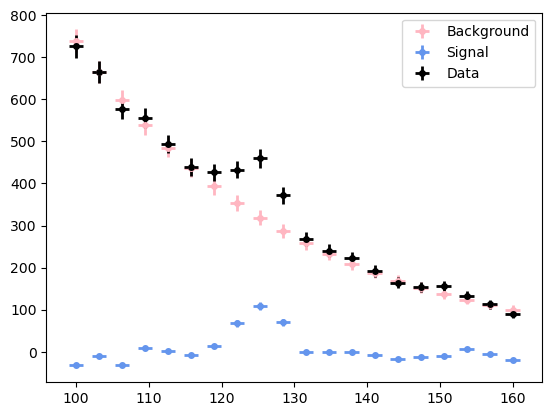

In [105]:
plt.errorbar(mgg_bins, background, np.sqrt(background), np.full(nBins, 1), color='lightpink', marker='o', lw=0,elinewidth=2, zorder=999, markersize=4, label='Background')
plt.errorbar(mgg_bins, signal, np.sqrt(signal), np.full(nBins, 1), color='cornflowerblue', marker='o', lw=0,elinewidth=2, zorder=999, markersize=4, label='Signal')

plt.errorbar(mgg_bins, data, np.sqrt(data), np.full(nBins, 1), color='k', marker='o', lw=0,elinewidth=2, zorder=999, markersize=4, label='Data')


plt.legend()


In [130]:
specs = {'channels': [{'name': 'GammaGamma_Higgs',
    'samples': [
    {'name': '4b_Signal',
    'data': signal,
    'modifiers': [
        # Signal Strength
        {'name': 'mu', "type": "normfactor", "data": None}
        ]},
    {'name': 'Background',
    'data': background,
    'modifiers': [
        # Normalisation Uncertainty / Normal : GP Uncertainty
        {'name': 'NormUncertainty', "type": "normsys", "data": {"hi": 1.02, "lo": 0.98}},
        # Correlated Shape
        {'name': f'CorrBackground', "type": "histosys", "data": {"hi_data": background+gamma_noise , "lo_data": background-gamma_noise}},
        ]},                            
    ]}],
    "observations": [
    {
    "name": 'GammaGamma_Higgs',
    "data": data
    }
    ],
    "measurements": [
        {
        "name": "Measurement",
        "config": {
            "poi": "mu",
            "parameters": []
        }
        }
    ],
    "version": "1.0.0"}

In [131]:
workspace = pyhf.Workspace(specs)
model = workspace.model()

observed = workspace.observations['GammaGamma_Higgs']

from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

with open('GammaGamma_Higgs.json', 'w') as f:
    f.write(json.dumps(specs, indent=2, cls=NumpyArrayEncoder))


### Inference

In [132]:
workspace = pyhf.Workspace(specs)
workspace

model = workspace.model()

data = workspace.observations['GammaGamma_Higgs']

unconstr_priors = {
    # 'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [0.5], 'beta': [5.]}
}


n_draws = 1000

In [138]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(n_draws)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [CorrBackground]
>Metropolis: [mu]
>Metropolis: [NormUncertainty]


/home/iwsatlas1/mhorstm/.local/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [CorrBackground, Expected_Data, NormUncertainty, mu]


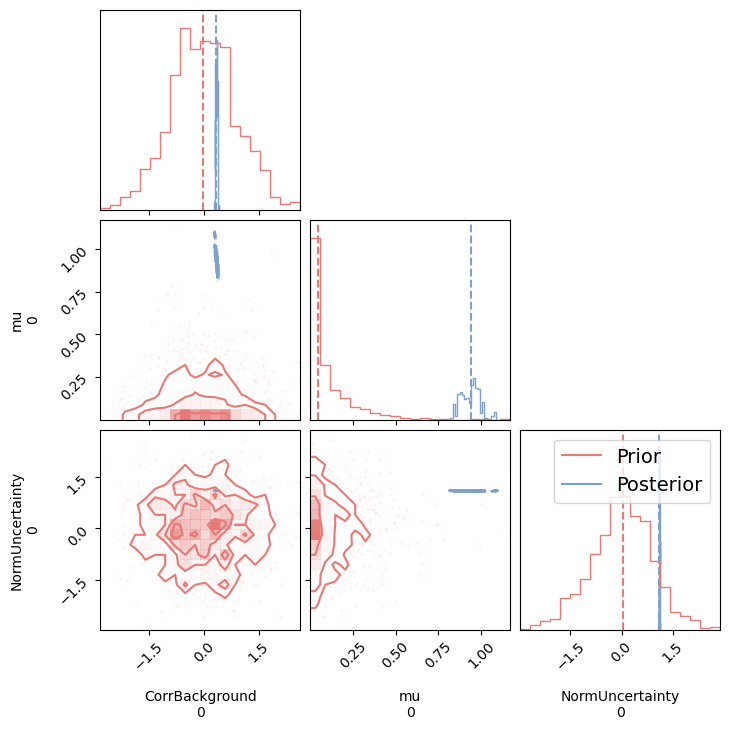

In [134]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(prior_pred.prior, quantiles=[0.5], color = rosa, fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color=rosa, label='Prior')),
            (mlines.Line2D([], [], color=blue, label='Posterior'))
        ], loc="upper right", fontsize=14)

Text(0.5, 0, '$m_{{SH}}$')

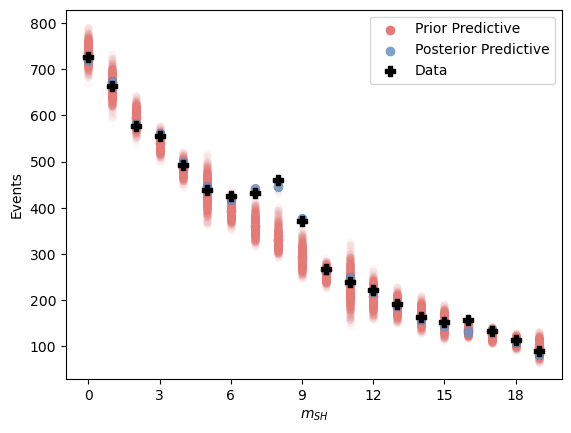

In [135]:
plotting.prior_posterior_predictives(model, data, post_pred, prior_pred, 3)
plt.xlabel('$m_{{SH}}$')

array([[<Axes: title={'center': 'CorrBackground'}>,
        <Axes: title={'center': 'CorrBackground'}>],
       [<Axes: title={'center': 'NormUncertainty'}>,
        <Axes: title={'center': 'NormUncertainty'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

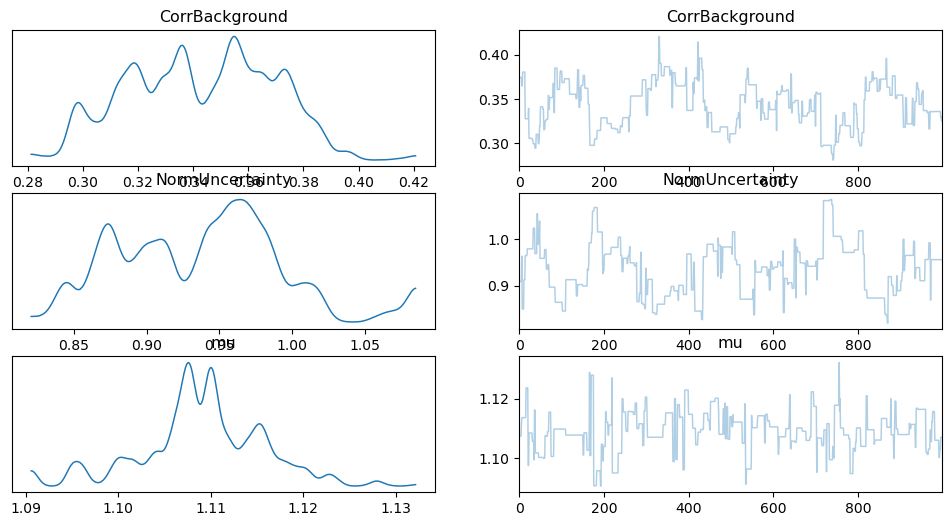

In [136]:
az.plot_trace(post_data)